In [27]:
from pathlib import Path
import gzip
from Bio import SeqIO
from statistics import mean
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

data_path = Path("../data/Arabidopsis_thaliana.TAIR10.dna.chromosome.1.fa.gz")

def load_record(path: Path):
    opener = gzip.open if path.suffixes and path.suffixes[-1].lower() == ".gz" else open
    with opener(path, "rt") as handle:
        return next(SeqIO.parse(handle, "fasta"))

record = load_record(data_path)
sequence = record.seq
chrom = record.id
seq_len = len(sequence)

print(f"Record: {record.id}")
print(f"Length: {seq_len:,} bp")



Record: 1
Length: 30,427,671 bp


In [28]:
from typing import List, Dict, Optional

window_size = 1000  # bp
max_windows = 10000  # set an int to truncate; None covers the full sequence

def make_windows(seq, size: int, max_windows: Optional[int]) -> List[Dict]:
    seq_str = str(seq)
    limit = min(len(seq_str), max_windows * size)
    windows = []
    for start in range(0, limit, size):
        segment = seq_str[start : start + size]
        windows.append({
            "start": start,  # 0-based inclusive
            "end": start + len(segment),  # 0-based exclusive
            "seq": segment,
        })
    return windows

windows = make_windows(sequence, window_size, max_windows)


print(f"Generated {len(windows)} window(s) of {window_size} bp")

Generated 10000 window(s) of 1000 bp


In [29]:

def gc_pct(seq: str) -> float:
    if not seq:
        return 0.0
    seq = seq.upper()
    gc = seq.count("G") + seq.count("C")
    return (gc / len(seq)) * 100 if len(seq) else 0.0

for w in windows:
    w["gc"] = gc_pct(w["seq"])

gc_values = [w["gc"] for w in windows]

print(f"GC mean: {mean(gc_values):.2f}%")
print(f"GC min/max: {min(gc_values):.2f}% / {max(gc_values):.2f}%")


GC mean: 36.63%
GC min/max: 17.20% / 59.00%


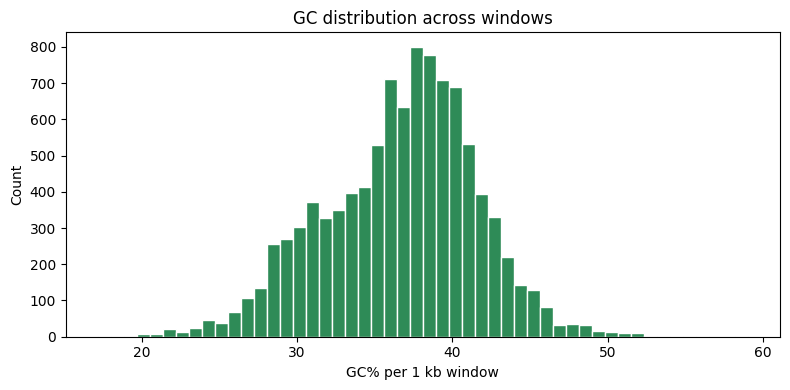

In [30]:
plt.figure(figsize=(8, 4))
plt.hist(gc_values, bins=50, color="seagreen", edgecolor="white")
plt.xlabel("GC% per 1 kb window")
plt.ylabel("Count")
plt.title("GC distribution across windows")
plt.tight_layout()
plt.show()

In [37]:
output_dir = Path("../outputs")
output_dir.mkdir(exist_ok=True)

fasta_path = output_dir / f"windows.fasta"
tsv_path   = output_dir / f"windows.tsv"

with open(fasta_path, "w") as fasta:
    for i, w in enumerate(windows):
        wid = f"{chrom}_w{i:05d}"
        header = (
            f">{wid} start={w['start']} end={w['end']} gc={w['gc']:.2f}"
        )
        fasta.write(header + "\n")
        fasta.write(w["seq"].upper() + "\n")


df = pd.DataFrame([
    {
        "id":     f"{chrom}_w{i:05d}",
        "chrom":  chrom,
        "start":  w["start"],
        "end":    w["end"],
        "length": len(w["seq"]),
        "gc_pct": round(w["gc"], 4),
    }
    for i, w in enumerate(windows)
])

df.to_csv(tsv_path, sep="\t", index=False)